In [1]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTETomek  ## for unsampling
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
import pickle #for serialization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# checking null values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<AxesSubplot:>

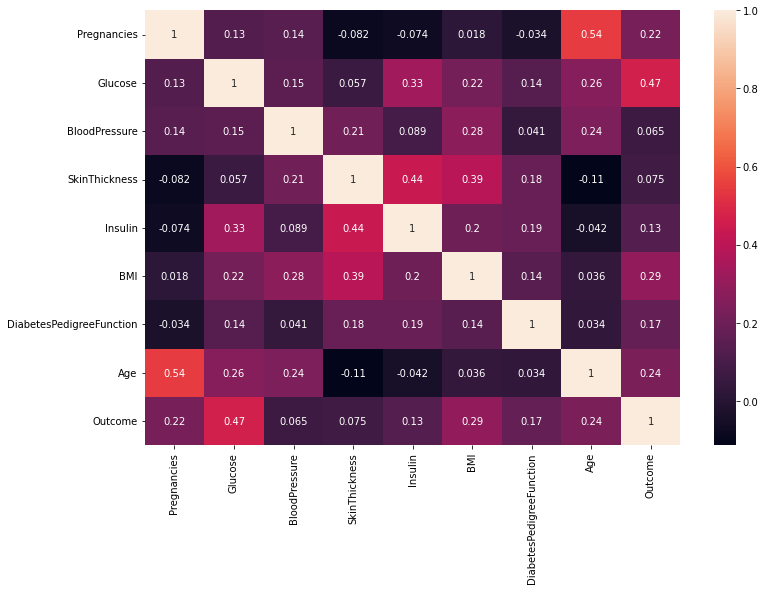

In [5]:
# co-relation matrix
cormat = df.corr()
plt.figure(figsize=(12,8))
# plot heatmap
sns.heatmap(cormat,annot=True)

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# but other than Pregnancies, other's min value 0 isn't justified. So we need to replace this median value
col = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for feature in col:
    df[feature].replace(0,df[feature].median(),inplace=True)

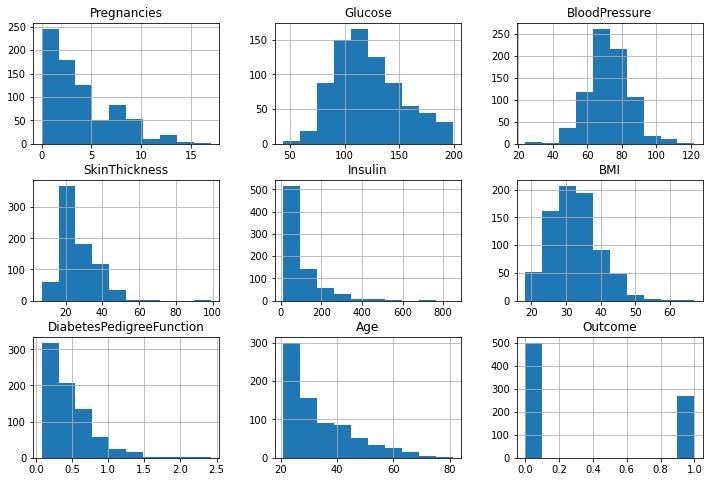

In [8]:
# histogram of each feature
p = df.hist(figsize=(12,8))

In [9]:
# split the dependent and independent features
X = df.drop("Outcome",axis=1)
Y = df['Outcome']
print(X.shape,Y.shape)

(768, 8) (768,)


In [10]:
Y.value_counts()
# there is inbalance in dataset

0    500
1    268
Name: Outcome, dtype: int64

### As there are only 39% of data for class- 1 records in the dataset the model might get baised
The problem caused by imbalanced dataset is it sort of creates bias towards one class thus leading to wrong predictions
## Upsampling
It is nothing but adding more copies to our minority class.Good option when we have small amount of
data

In [11]:
smote = SMOTETomek(random_state=42,n_jobs=-1) # library used for unsampling
X_,Y_= smote.fit_resample(X,Y)
print(X_.shape,Y_.shape)

(946, 8) (946,)


In [12]:
Y_.value_counts()
# now the data is kinda balanced

1    473
0    473
Name: Outcome, dtype: int64

In [13]:
x_train,x_test,y_train,y_test=train_test_split(X_,Y_,test_size=0.25,random_state=42)
print(x_train.shape,y_train.shape)

(709, 8) (709,)


In [14]:
# but other than Pregnancies, other's min value 0 isn't justified. So we need to replace this median value
col = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for feature in col:
    x_train[feature].replace(0,x_train[feature].median(),inplace=True)

In [15]:
# it's a classification problem, so we are use Random Forrest Classifier
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(x_train,y_train)

RandomForestClassifier(n_jobs=-1)

In [16]:
# cross validation for training dataset
score = cross_val_score(rf,x_train,y_train,cv=10,n_jobs=-1)
score

array([0.78873239, 0.84507042, 0.84507042, 0.78873239, 0.81690141,
       0.84507042, 0.90140845, 0.87323944, 0.85915493, 0.81428571])

In [17]:
score.mean()

0.8377665995975855

In [18]:
# cross validation for testing dataset
score_test = cross_val_score(rf,x_test,y_test,cv=10,n_jobs=-1)
score_test

array([0.79166667, 0.79166667, 0.83333333, 0.75      , 0.75      ,
       0.70833333, 0.75      , 0.7826087 , 0.65217391, 0.86956522])

In [19]:
score_test.mean()

0.7679347826086957

In [20]:
# cross validation for training dataset
score = cross_val_score(rf,x_train,y_train,cv=10,n_jobs=-1)
score

array([0.8028169 , 0.84507042, 0.84507042, 0.77464789, 0.81690141,
       0.87323944, 0.87323944, 0.87323944, 0.88732394, 0.82857143])

In [21]:
pred = rf.predict(x_test)
confusion_matrix(y_test,pred)

array([[104,  34],
       [  8,  91]], dtype=int64)

In [22]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       138
           1       0.73      0.92      0.81        99

    accuracy                           0.82       237
   macro avg       0.83      0.84      0.82       237
weighted avg       0.84      0.82      0.82       237



## Hyperparameter Tuning
Hyperparamerters are those paramerters whose values are used to control the learning process 

In [23]:
 RandomForestClassifier()

RandomForestClassifier()

In [24]:
# some of the hyperparameters of RandomForestClassifier

#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
#Number of features to consider at every split
max_features = ['auto','sqrt','log2']
#Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10,1000,10)]
#Minimum number of samples required to splitanode
min_samples_split = [2,5,10,14]
#Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4,6,8]
#Create the random grid
random_grid = {'n_estimators':n_estimators,
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [25]:
rs = RandomizedSearchCV(rf,random_grid,cv=10,verbose=2,n_jobs=-1)  # pick random values from each pair in random_grid
rs.fit(x_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1),
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [26]:
rs.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 340,
 'criterion': 'entropy'}

In [27]:
pred = rs.predict(x_test)
confusion_matrix(y_test,pred)

array([[105,  33],
       [  6,  93]], dtype=int64)

In [28]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       138
           1       0.74      0.94      0.83        99

    accuracy                           0.84       237
   macro avg       0.84      0.85      0.84       237
weighted avg       0.86      0.84      0.84       237



#### Purpose of pickle file => 
it's the process of converting a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network

In [29]:
model_file = open("model.pkl","wb") 
pickle.dump(rs,model_file)
model_file.close()  # always remember to close it

### Testing the pickle file

In [30]:
model = pickle.load(open("model.pkl","rb"))
pred = model.predict(X[:50])  # first 50 datapoints from original dataset

In [31]:
confusion_matrix(Y[:50],pred)

array([[22,  3],
       [ 0, 25]], dtype=int64)

## How Pickle files help us predict 

In [32]:
model_test = pickle.load(open("model.pkl","rb"))

In [35]:
model_test.predict([[150,150,100,23,125,28,1,42]])   # have to provides all data in 2D array form

array([1], dtype=int64)

In [37]:
a = model.predict_proba([[150,150,100,23,125,28,1,42]])
a[0]

array([0.19, 0.81])